# Geo

1. Plot sample distribution on world map.
1. Plot timeline by study.

---
## Setup

### Import Modules

In [1]:
import geopandas
import matplotlib.pyplot as plt
from matplotlib import gridspec, colors
import os
import shapely
import treetime
from Bio import Phylo
import math
import seaborn as sns

### File Paths

In [2]:
metadata_path = "../../docs/results/latest/metadata/metadata.tsv"
outdir = "../../docs/results/latest/geo"
tree_path = "../../docs/results/latest/parse_tree/parse_tree.xml"
tree_df_path = "../../docs/results/latest/parse_tree/parse_tree.tsv"
# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

### Variables

In [79]:
from config import *

GEO_ATTR = "Province"
CRS="epsg:4326"
WEB_MERCATOR_CRS = "epsg:3857"
NAME_COL = "Sample"
DATE_COL = "Date"

SCRIPT_NAME = "geo"

#pd.set_option("display.max_rows", 10, "display.max_columns", None)

### Read input tree and dataframe

In [4]:
tree = Phylo.read(tree_path, "phyloxml")
tree.ladderize(reverse=False)

tree_df = pd.read_csv(tree_df_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index("Name", inplace=True)

tree_df

,UFboot,aLRT,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment
Name,,,,,,,,,,,,,,,,,,,,
NODE0,100,100,0.000000e+00,red,0.000000,16.975763,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA3541827,NA,NA,3.891500e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age Plague,Bronze Age,Bronze Age,SAMEA3541827,KEEP: SRA Ancient
NODE2,100,81.3,1.370850e-05,red,0.000014,2.968750,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA104233046,NA,NA,2.760700e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age Plague,Bronze Age,Bronze Age,SAMEA104233046,KEEP: SRA Ancient
NODE4,100,100,1.114500e-06,red,0.000015,3.937500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_000269265.1_ASM26926v1_genomic,NA,NA,4.688000e-07,grey,0.000076,520.000000,PY-36,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141469,KEEP: Assembly Modern
GCA_000269385.1_ASM26938v1_genomic,NA,NA,2.340000e-08,grey,0.000075,521.000000,PY-66,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141487,KEEP: Assembly Modern
NODE1041,100,97.9,1.172000e-06,red,0.000076,522.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### Import Dataframe as Pandas

In [5]:
metadata_df = pd.read_csv(metadata_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
metadata_df.fillna(NO_DATA_CHAR, inplace=True)
metadata_df.set_index("Sample", inplace=True)

### Parse Dates

In [6]:
dates_dict = treetime.utils.parse_dates(metadata_path, 
                                   date_col=DATE_COL, 
                                   name_col = NAME_COL)


Attempting to parse dates...
	Using column 'Sample' as name. This needs match the taxon names in the tree!!
	Using column 'Date' as date.


### Convert Dataframe to GeoPandas

In [7]:
# For samples with no province info, set to country
for rec in metadata_df.iterrows():
    sample = rec[0]
    data = rec[1]
    province = data["Province"]
    if province == NO_DATA_CHAR:
        # Try to set latlon to country
        country = data["Country"]
        if country != NO_DATA_CHAR:
            metadata_df.at[sample, "Province"] = data["Country"]
            metadata_df.at[sample, "ProvinceLat"] = data["CountryLat"]
            metadata_df.at[sample, "ProvinceLon"] = data["CountryLon"]
            

In [80]:
# Remove missing data
df = metadata_df[metadata_df[GEO_ATTR + "Lon"] != NO_DATA_CHAR]

geometry = [shapely.geometry.Point(xy) for xy in zip(df[GEO_ATTR + "Lon"], df[GEO_ATTR + "Lat"])]
#df = df.drop([GEO_ATTR + "Lon", GEO_ATTR + "Lat"], axis=1)
#WGS84 = "epsg:4326"
gdf_points = geopandas.GeoDataFrame(df, crs=CRS, geometry=geometry)

gdf_points

,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,geometry
Sample,,,,,,,,,,,,,,,
GCA_009909635.1_ASM990963v1_genomic,9_10,1923,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,NA,NA,NA,SAMN13632815,KEEP: Assembly Modern,POINT (40.79579 47.62225)
GCA_009669545.1_ASM966954v1_genomic,42126,2006,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,POINT (85.46335 42.48050)
GCA_009669555.1_ASM966955v1_genomic,42123,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,POINT (85.46335 42.48050)
GCA_009669565.1_ASM966956v1_genomic,42118,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,POINT (85.46335 42.48050)
GCA_009669605.1_ASM966960v1_genomic,42117,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722922,KEEP: Assembly Modern,POINT (85.46335 42.48050)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IP542,IP542,1952,-69,Kenya,Kenya,1.44197,38.4314,1.44197,38.4314,Antiqua,1.ANT,1.ANT1,IP542,KEEP: Local Modern,POINT (38.43140 1.44197)
IP543,IP543,1953,-68,Democratic Republic of the Congo,Democratic Republic of the Congo,-2.98143,23.8223,-2.98143,23.8223,Antiqua,1.ANT,1.ANT1,IP543,KEEP: Local Modern,POINT (23.82226 -2.98143)
IP557,IP557,1963,-58,Iran,Kurdistan,32.6475,54.5644,35.6728,47.0124,Medievalis,2.MED,2.MED1,IP557,KEEP: Local Modern,POINT (47.01244 35.67280)


### Prep Plotting Data

This should be a function, too repetitive

In [81]:
# --------------------------------------
# World Basemap
world_polygons = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Data selection
# --------------------------------------
# Keller et al. 2019
gdf_keller = gdf_points[(gdf_points["BioSampleComment"].str.contains("Keller 2019")) & (gdf_points["BioSampleComment"].str.contains("Modern"))]
df_keller = tree_df[(tree_df["BioSampleComment"].str.contains("Keller 2019")) & (tree_df["BioSampleComment"].str.contains("Modern"))]
gdf_this_study = gdf_points[(gdf_points["BioSampleComment"].str.contains("Modern"))]
df_this_study = tree_df[(tree_df["BioSampleComment"].str.contains("Modern"))]
gdf_ancient = gdf_points[gdf_points["BioSampleComment"].str.contains("Ancient")]
df_ancient = tree_df[tree_df["BioSampleComment"].str.contains("Ancient")]

plot_dict = {"Ancient DNA" : {
                  "gdf" : gdf_ancient,
                  "df" : df_ancient,    
                  "geo_count" : {},
                  "geo_size" : [],
                  "date_count" : {}, 
                  "date_list" : [], 
              },  
              "This Study" : {
                  "gdf" : gdf_this_study,  
                  "df" : df_this_study,                   
                  "geo_count" : {},
                  "geo_size" : [],
                  "date_count" : {},   
                  "date_list" : [],                   
              },              
             "Keller et al. 2019" : {
                  "gdf" : gdf_keller,             
                  "df" : df_keller,                  
                  "geo_count" : {},
                  "geo_size" : [],
                  "date_count" : {},   
                  "date_list" : [],                  
              },           
             }

tree_df["Study_Color"] = ["black" for row in range(0,len(tree_df))]  

layer = 0
for dataset in plot_dict:
    # Iterate through records for each dataset
    layer += 1
    
    df = plot_dict[dataset]["df"]
    gdf = plot_dict[dataset]["gdf"]
    
    # Add the study color to the dataframe
    for c in tree.find_clades():
        # Skip internal nodes
        if not c.is_terminal(): continue
        # If node is in the datafame and hasn't been recolored
        # Note, later datasets in dict overwrite earlier
        if c.name in df.index:
            color = colors.rgb2hex(DISC_CMAP(layer-1))
            tree_df.at[c.name, "Study_Color"] = color
            
    for rec in gdf.iterrows():
        sample = rec[0]
        date = dates_dict[sample]
        geo = rec[1][GEO_ATTR]

        # Convert date to float and get mean if range
        if type(date) == list:
            date = sum(dates_dict[sample]) / 2
        date = float(date)     
        plot_dict[dataset]["date_list"].append(date)
        
        if date not in plot_dict[dataset]["date_count"]:
            plot_dict[dataset]["date_count"][date] = 0
        plot_dict[dataset]["date_count"][date] += 1   
        
        # Add geo info
        if geo not in plot_dict[dataset]["geo_count"]:
            plot_dict[dataset]["geo_count"][geo] = 0
        plot_dict[dataset]["geo_count"][geo] += 1   
        
    # Drop duplicate entries for geo plotting
    gdf = gdf.drop_duplicates(subset = GEO_ATTR, keep = 'first')
    for geo in gdf[GEO_ATTR]:
        size = plot_dict[dataset]["geo_count"][geo]
        plot_dict[dataset]["geo_size"].append(size)
        
    plot_dict[dataset]["gdf"] = gdf

# Show dataframe 
tree_df

,UFboot,aLRT,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Study_Color
Name,,,,,,,,,,,,,,,,,,,,,
NODE0,100,100,0.000000e+00,red,0.000000,16.975763,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,black
SAMEA3541827,NA,NA,3.891500e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age Plague,Bronze Age,Bronze Age,SAMEA3541827,KEEP: SRA Ancient,#1f77b4
NODE2,100,81.3,1.370850e-05,red,0.000014,2.968750,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,black
SAMEA104233046,NA,NA,2.760700e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age Plague,Bronze Age,Bronze Age,SAMEA104233046,KEEP: SRA Ancient,#1f77b4
NODE4,100,100,1.114500e-06,red,0.000015,3.937500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_000269265.1_ASM26926v1_genomic,NA,NA,4.688000e-07,grey,0.000076,520.000000,PY-36,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141469,KEEP: Assembly Modern,#ff7f0e
GCA_000269385.1_ASM26938v1_genomic,NA,NA,2.340000e-08,grey,0.000075,521.000000,PY-66,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141487,KEEP: Assembly Modern,#ff7f0e
NODE1041,100,97.9,1.172000e-06,red,0.000076,522.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,black


### Plot

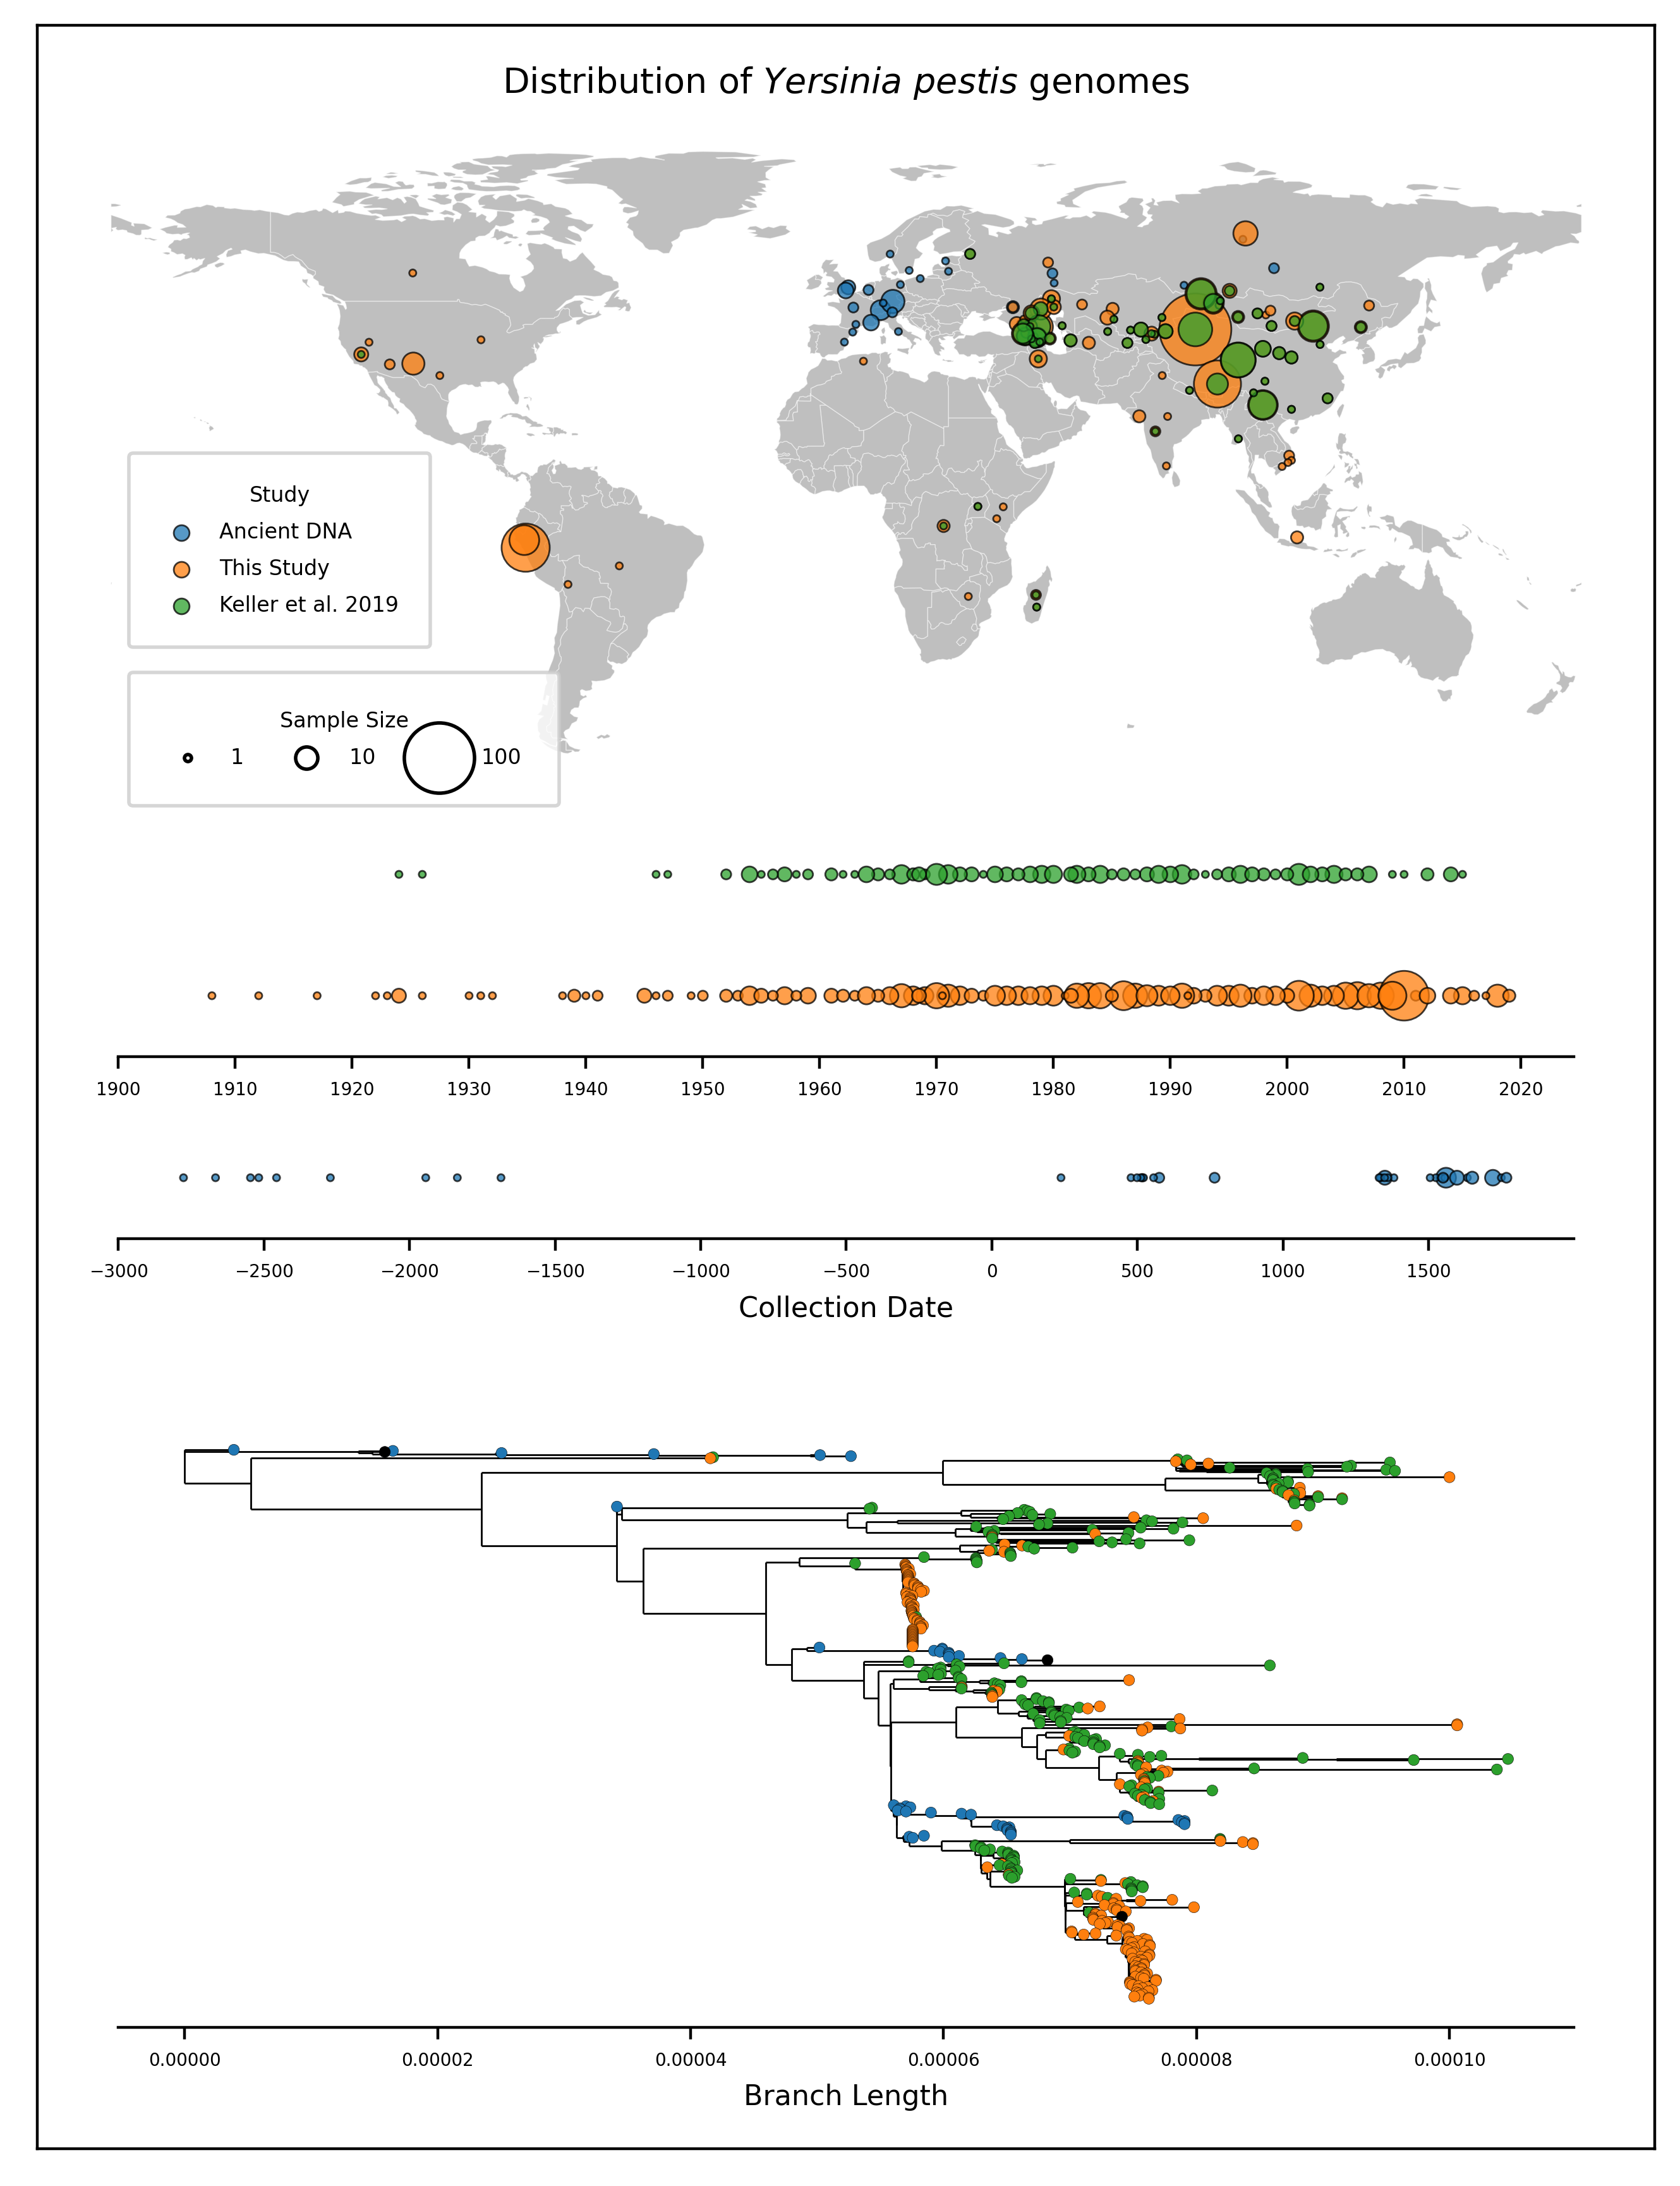

In [82]:
fig = plt.figure(figsize=figsize, dpi=dpi)
# Map axis
ax0 = fig.add_axes([0, -0.9, 1, 1.75])
ax1 = fig.add_axes([0, 0, 1, 1])
# Timeline axes
ax2 = fig.add_axes([0.05, 0, 0.9, 0.2])
ax3 = fig.add_axes([0.05, -0.15, 0.9, 0.1])
# Tree axis
ax4 = fig.add_axes([0.05, -0.8, 0.9, 0.5])

# Make everything appear larger
marker_scale = 4

# --------------------------------------
# World Basemap
world_polygons.plot(ax=ax1, 
                    zorder=1, 
                    alpha=0.5, 
                    color="grey",
                    edgecolor="white", 
                    linewidth=0.25,
                   )

layer = 0
for dataset in plot_dict.keys():
    gdf = plot_dict[dataset]["gdf"]
    layer += 1
    # Plot map
    geo_size = plot_dict[dataset]["geo_size"]
    gdf.plot(ax=ax1, 
             zorder=layer, 
             markersize=[s*marker_scale for s in geo_size],
             color=DISC_CMAPLIST[layer-1],
             edgecolor="black",
             linewidths=0.5,
             label=dataset,
             legend=True,
             alpha=0.75,
             )

    # Plot timeline
    date_count = plot_dict[dataset]["date_count"]
    
    # Plot ancient timeline separately    
    if "Ancient" in dataset:
        ax3.scatter(x=list(date_count.keys()), 
                y=[layer for i in range(len(date_count))],
                s=[s*marker_scale for s in list(date_count.values())],
                zorder=layer,   
                color=DISC_CMAPLIST[layer-1],
                edgecolor="black",
                linewidths=0.5,
                alpha=0.75,
               )
      
    else:
        ax2.scatter(x=list(date_count.keys()), 
                y=[layer for i in range(len(date_count))],
                s=[s*marker_scale for s in list(date_count.values())],
                zorder=layer,   
                color=DISC_CMAPLIST[layer-1],
                edgecolor="black",
                linewidths=0.5,
                alpha=0.75,
               )
        
# Plot tree     
Phylo.draw(tree,
           axes=ax4,
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False,
          )

tip_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL)]
ax4.scatter(data=tip_data, 
            x="coord_x", 
            y="coord_y", 
            s=10, 
            c="Study_Color", 
            edgecolor="black", 
            linewidth=0.1, 
            zorder=2)

# --------------------------------------
# Limits

# Sorry Antarctica
ax1.set_ylim(-63,)

ax2.set_ylim(1.5,3.5)
ax3.set_xlim(-3000,2000)


x_buffer = max(tree_df["coord_x"]) * 0.05
y_buffer = math.ceil(len(tree.get_terminals()) * 0.05)

ax4.set_xlim(0 - x_buffer, max(tree_df["coord_x"]) + x_buffer)
ax4.set_ylim(len(tree.get_terminals()) + y_buffer, 0 - y_buffer)

# --------------------------------------
# Labels

ax0.set_xticks([])
ax0.set_yticks([])

ax1.set_title("Distribution of " 
          + "$\it Yersinia$" 
          + " " 
          + "$\it pestis$"
          + " " 
          + "genomes")
ax1.axis('off')

ax2.set_xticks([x for x in range(1900,2021,10)])
ax2.set_yticks([])

ax3.set_xticks([x for x in range(-3000,1901,500)])
ax3.set_yticks([])

ax3.set_xlabel("Collection Date")

ax4.set_xlabel("Branch Length")
ax4.set_ylabel("")
ax4.set_yticks([])
# --------------------------------------
# Layout
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(False)

#ax3.xaxis.tick_top()

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(True)
ax3.spines['left'].set_visible(False)

ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(True)
ax4.spines['left'].set_visible(False)

# --------------------------------------
# Legend

color_legend = ax1.legend(loc="center left",
                          bbox_to_anchor=(0.05, 0.35),
                          ncol=1,
                          borderpad = 1.5, 
                          title="Study", 
                          title_fontsize=6,
                          fontsize=6, 
                          frameon=True,
                         )
for handle in color_legend.legendHandles:
    handle.set_sizes([20])


size_l1  = plt.scatter([],[], s=1 * marker_scale, edgecolors='black', color="white")
size_l10 = plt.scatter([],[], s=10 * marker_scale, edgecolors='black', color="white")
size_l100 = plt.scatter([],[], s=100 * marker_scale, edgecolors='black', color="white")

size_labels = ["1", "10", "100"]

size_legend = plt.legend([size_l1, size_l10, size_l100], 
                 size_labels,
                 loc="upper left", 
                 bbox_to_anchor=(0, 2.25),
                 ncol=3,
                 borderpad = 1.8, 
                 title="Sample Size", 
                 title_fontsize=6,
                 fontsize=6, 
                 frameon=True,
                 #labelspacing=2,
                 handletextpad=1,
                )
 
# Add multiple legends as artists
#ax1.add_artist(color_legend)
#ax1.add_artist(size_legend)


# --------------------------------------------
# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_map_timeline." + FMT)
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

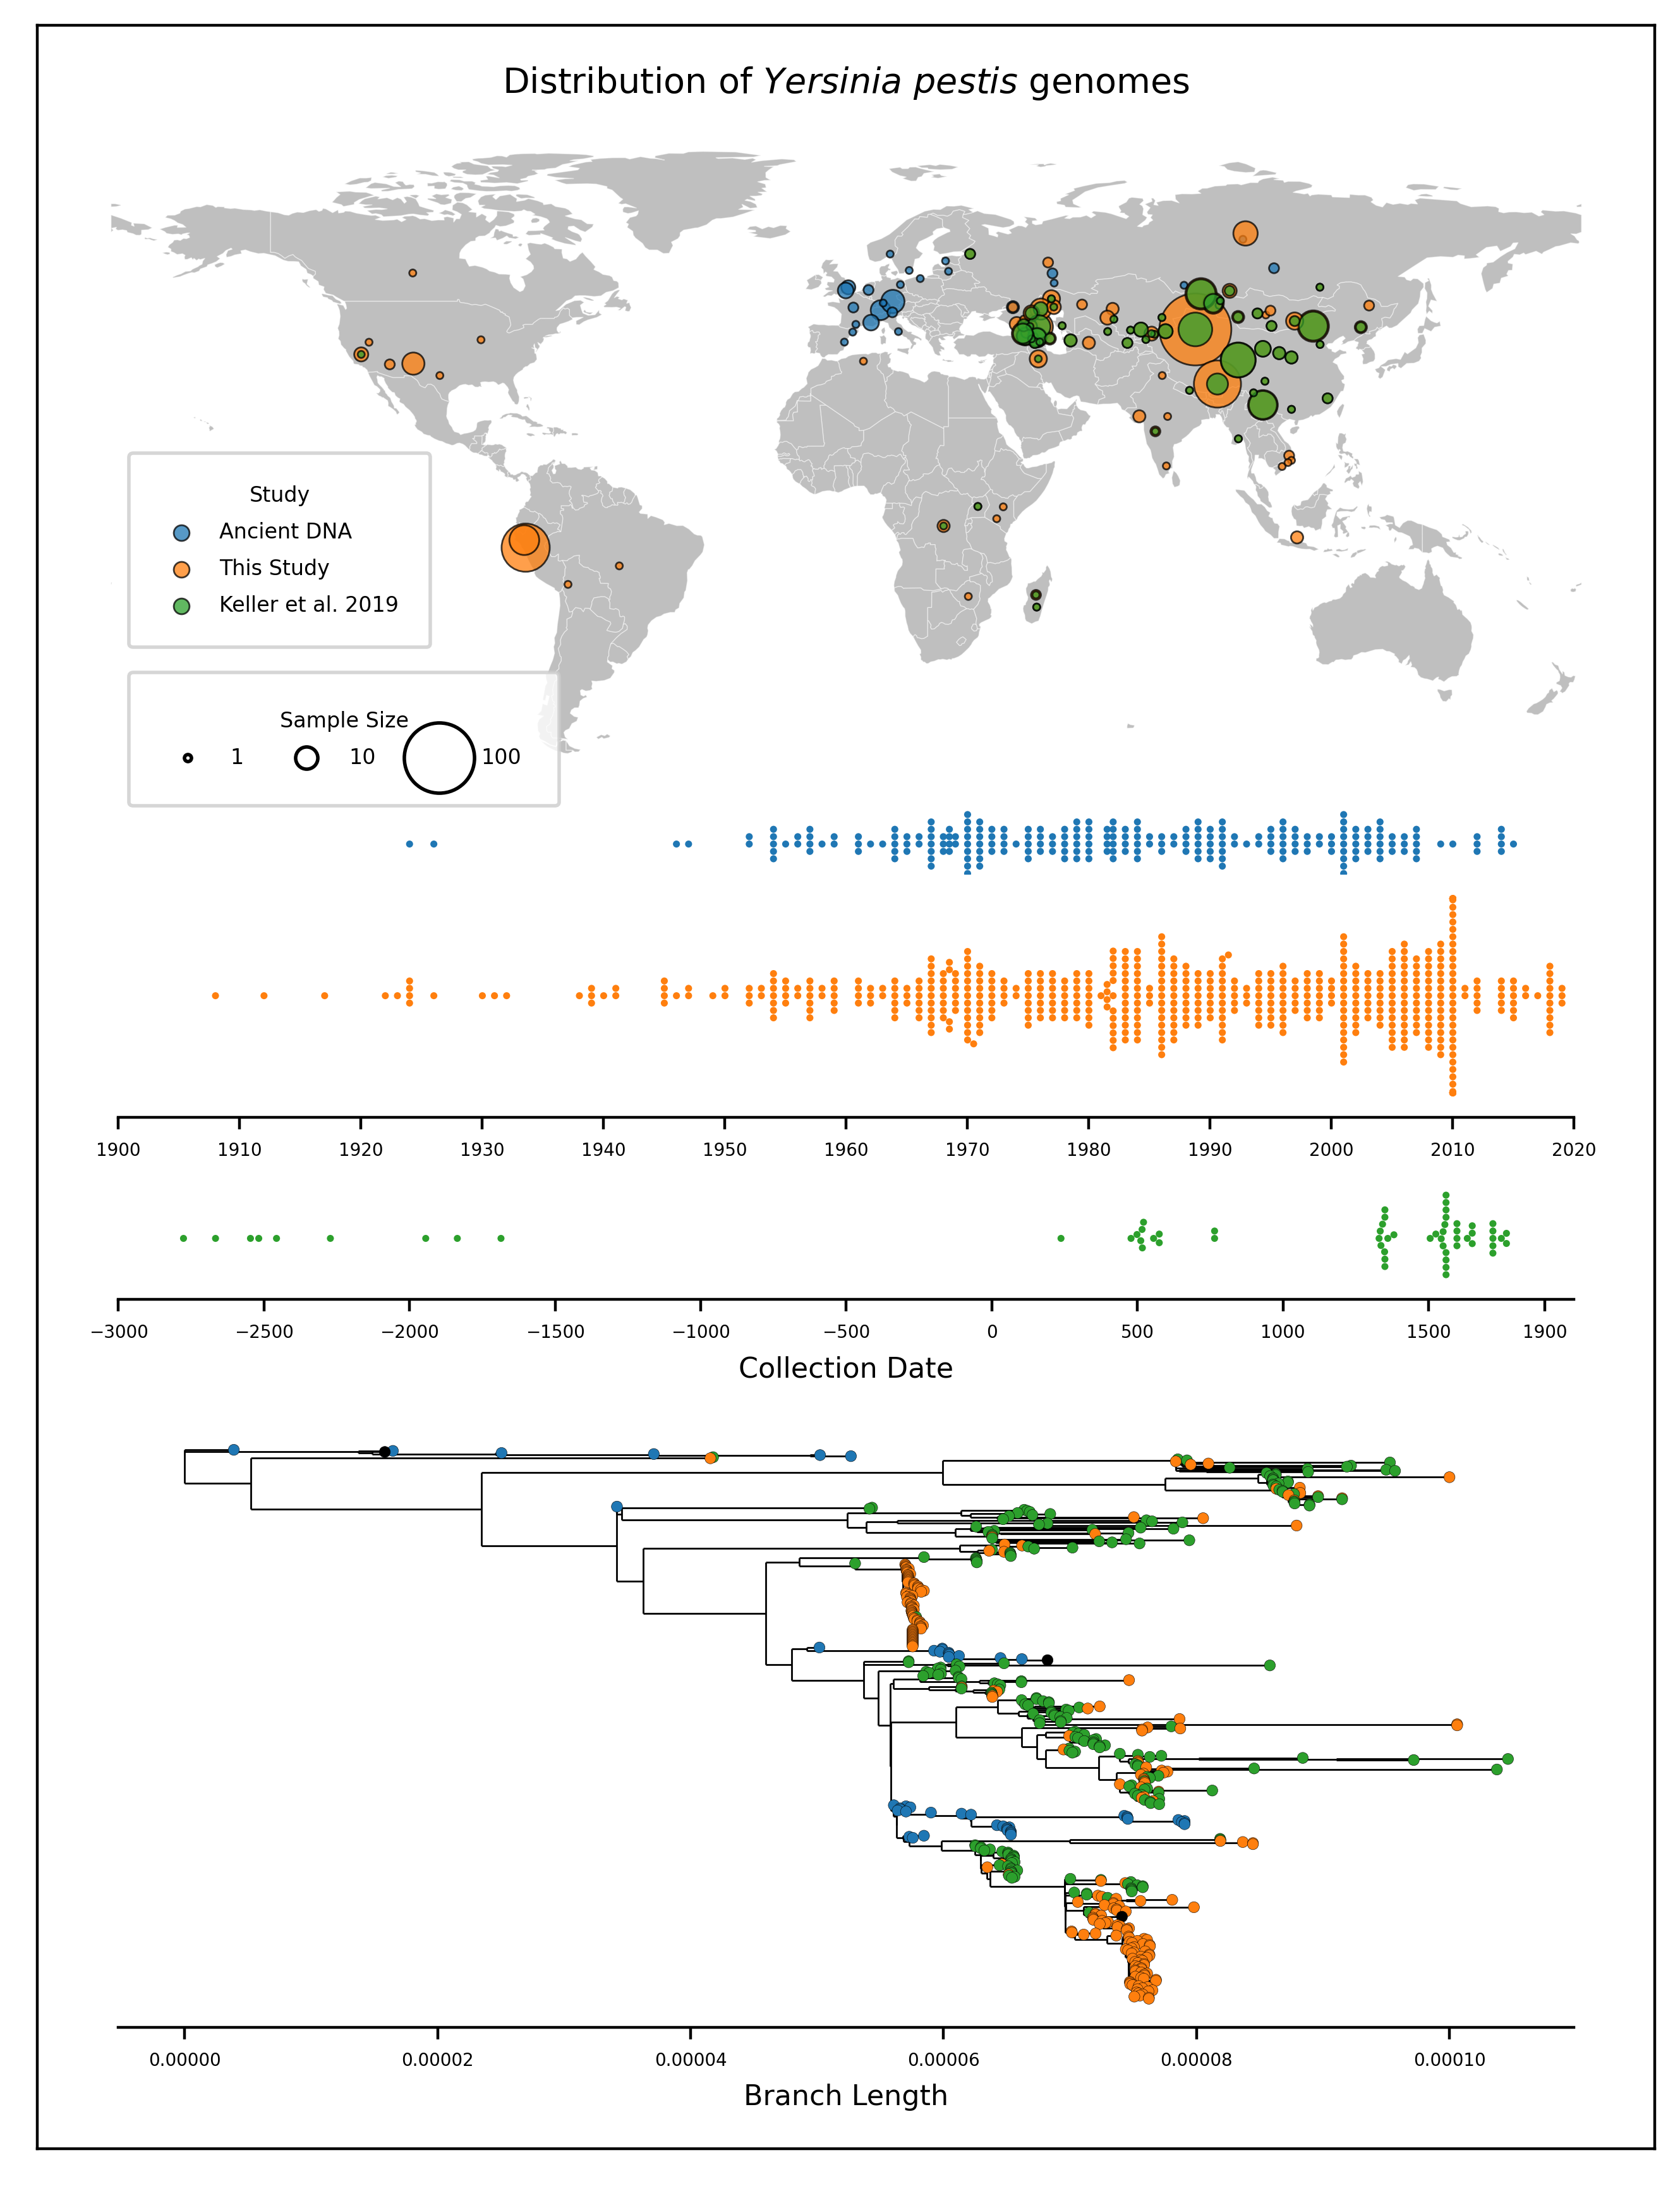

In [83]:
fig = plt.figure(figsize=figsize, dpi=dpi)
# Map axis
ax0 = fig.add_axes([0, -0.9, 1, 1.75])
ax1 = fig.add_axes([0, 0, 1, 1])
# Timeline axes
ax2 = fig.add_axes([0.05, 0.1, 0.9, 0.15])
ax3 = fig.add_axes([0.05, -0.05, 0.9, 0.20])
ax4 = fig.add_axes([0.05, -0.20, 0.9, 0.10])
# Tree axis
ax5 = fig.add_axes([0.05, -0.8, 0.9, 0.5])

# Make everything appear larger
marker_scale = 4

# --------------------------------------
# World Basemap
world_polygons.plot(ax=ax1, 
                    zorder=1, 
                    alpha=0.5, 
                    color="grey",
                    edgecolor="white", 
                    linewidth=0.25,
                   )

layer = 0
for dataset in plot_dict.keys():
    gdf = plot_dict[dataset]["gdf"]
    layer += 1
    
    # Plot map
    geo_size = plot_dict[dataset]["geo_size"]
    gdf.plot(ax=ax1, 
             zorder=layer, 
             markersize=[s*marker_scale for s in geo_size],
             color=DISC_CMAPLIST[layer-1],
             edgecolor="black",
             linewidths=0.5,
             label=dataset,
             legend=True,
             alpha=0.75,
             )

# Plot timeline
sns.swarmplot(x=plot_dict["Keller et al. 2019"]["date_list"], ax=ax2, size=2, color=DISC_CMAPLIST[0])
sns.swarmplot(x=plot_dict["This Study"]["date_list"], ax=ax3, size=2, color=DISC_CMAPLIST[1])
sns.swarmplot(x=plot_dict["Ancient DNA"]["date_list"], ax=ax4, size=2, color=DISC_CMAPLIST[2]) 


# Plot tree     
Phylo.draw(tree,
           axes=ax5,
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False,
          )

tip_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL)]
ax5.scatter(data=tip_data, 
            x="coord_x", 
            y="coord_y", 
            s=10, 
            c="Study_Color", 
            edgecolor="black", 
            linewidth=0.1, 
            zorder=2)

# --------------------------------------
# Limits

# Sorry Antarctica
ax1.set_ylim(-63,)

ax2.set_xlim(1900,2020)
ax3.set_xlim(1900,2020)
#ax2.set_ylim(1.5,3.5)

ax4.set_xlim(-3000,2000)

x_buffer = max(tree_df["coord_x"]) * 0.05
y_buffer = math.ceil(len(tree.get_terminals()) * 0.05)

ax5.set_xlim(0 - x_buffer, max(tree_df["coord_x"]) + x_buffer)
ax5.set_ylim(len(tree.get_terminals()) + y_buffer, 0 - y_buffer)

# --------------------------------------
# Labels

ax0.set_xticks([])
ax0.set_yticks([])

ax1.set_title("Distribution of " 
          + "$\it Yersinia$" 
          + " " 
          + "$\it pestis$"
          + " " 
          + "genomes")
ax1.axis('off')

ax2.axis('off')

ax3.set_xticks([x for x in range(1900,2021,10)])
ax3.set_yticks([])

ax4.set_xticks([x for x in range(-3000,1901,500)] + [1900])
ax4.set_yticks([])

ax4.set_xlabel("Collection Date")

ax5.set_xlabel("Branch Length")
ax5.set_ylabel("")
ax5.set_yticks([])
# --------------------------------------
# Layout

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(True)
ax3.spines['left'].set_visible(False)

ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(True)
ax4.spines['left'].set_visible(False)

ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(True)
ax5.spines['left'].set_visible(False)
# --------------------------------------
# Legend

color_legend = ax1.legend(loc="center left",
                          bbox_to_anchor=(0.05, 0.35),
                          ncol=1,
                          borderpad = 1.5, 
                          title="Study", 
                          title_fontsize=6,
                          fontsize=6, 
                          frameon=True,
                         )
for handle in color_legend.legendHandles:
    handle.set_sizes([20])


size_l1  = plt.scatter([],[], s=1 * marker_scale, edgecolors='black', color="white")
size_l10 = plt.scatter([],[], s=10 * marker_scale, edgecolors='black', color="white")
size_l100 = plt.scatter([],[], s=100 * marker_scale, edgecolors='black', color="white")

size_labels = ["1", "10", "100"]

size_legend = plt.legend([size_l1, size_l10, size_l100], 
                 size_labels,
                 loc="upper left", 
                 bbox_to_anchor=(0, 2.25),
                 ncol=3,
                 borderpad = 1.8, 
                 title="Sample Size", 
                 title_fontsize=6,
                 fontsize=6, 
                 frameon=True,
                 #labelspacing=2,
                 handletextpad=1,
                )
 
# Add multiple legends as artists
#ax1.add_artist(color_legend)
#ax1.add_artist(size_legend)


# --------------------------------------------
# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_map_timeline_swarm." + FMT)
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")


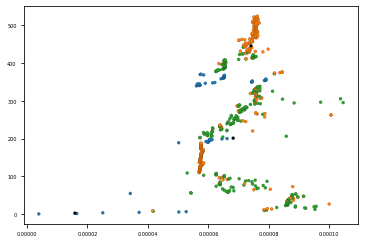

In [75]:
tip_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL)]
fig, ax1 = plt.subplots(1)

ax1.scatter(data=tip_data, 
            x="coord_x", 
            y="coord_y", 
            s=10, 
            c="Study_Color", 
            edgecolor="black", 
            linewidth=0.1, 
            zorder=2)